**MENGIMPORT SEMUA LIBRARY YANG DIBUTUHKAN**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Model

# INI TAMBAHAN DARI DENI YANG INGIN MENGGUNAKAN EfficientNetB1
from tensorflow.keras.applications import EfficientNetB1
#import plotly
#import plotly.express as px

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, load_img
import zipfile

**MENGIMPORT DATASET DARI KAGGLE**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dasa7753912/new-paddy-doctor-paddy-disease-classification
#!kaggle datasets download -d nirmalsankalana/rice-leaf-disease-image

Dataset URL: https://www.kaggle.com/datasets/dasa7753912/new-paddy-doctor-paddy-disease-classification
License(s): unknown
100% 2.17G/2.17G [01:40<00:00, 24.1MB/s]
100% 2.17G/2.17G [01:40<00:00, 23.2MB/s]


**MENGEKSTRAK DATASET YANG TELAH DI DOWNLOAD**

In [ ]:
!unzip -q new-paddy-doctor-paddy-disease-classification.zip

In [ ]:
#!unzip -q rice-leaf-disease-image.zip

**MENGHAPUS FILE ZIP**

In [ ]:
rm new-paddy-doctor-paddy-disease-classification.zip

In [ ]:
#rm rice-leaf-disease-image.zip

**MENGHAPUS GAMBAR PENYAKIT YANG TIDAK DI PERLUKAN DARI FOLDER train_images DI DALAM FOLDER paddy-disease-classification**

In [ ]:
# Membuat daftar nama folder yang ingin dihapus
folders_to_remove = [
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'dead_heart',
    'downy_mildew',
    'hispa'
]

# Menghapus setiap folder dengan cara iterasi
base_path = '/content/paddy-disease-classification/train_images/'
for folder in folders_to_remove:
    shutil.rmtree(base_path + folder)


**MEMBAGI DATASET UNTUK VALIDASI MODEL**

In [ ]:
dataset_path = "/content/paddy-disease-classification"
train_dir = os.path.join(dataset_path, "train_images")

In [ ]:
import shutil
validation_dir = os.path.join(dataset_path, "validation_images")
os.makedirs(validation_dir, exist_ok=True)

In [ ]:
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(validation_dir, cls)
    os.makedirs(val_cls_path, exist_ok=True)
    images = os.listdir(cls_path)
    np.random.shuffle(images)
    val_count = int(0.2 * len(images)) #0.2 for validation images
    for img in images[:val_count]:
        shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_path, img))

**MELAKUKAN EDA (EKSPLORASI DATA ANALISIS)**

Number of Classes: 5
Name of Classes: ['brown_spot', 'bacterial_leaf_blight', 'normal', 'blast', 'tungro']


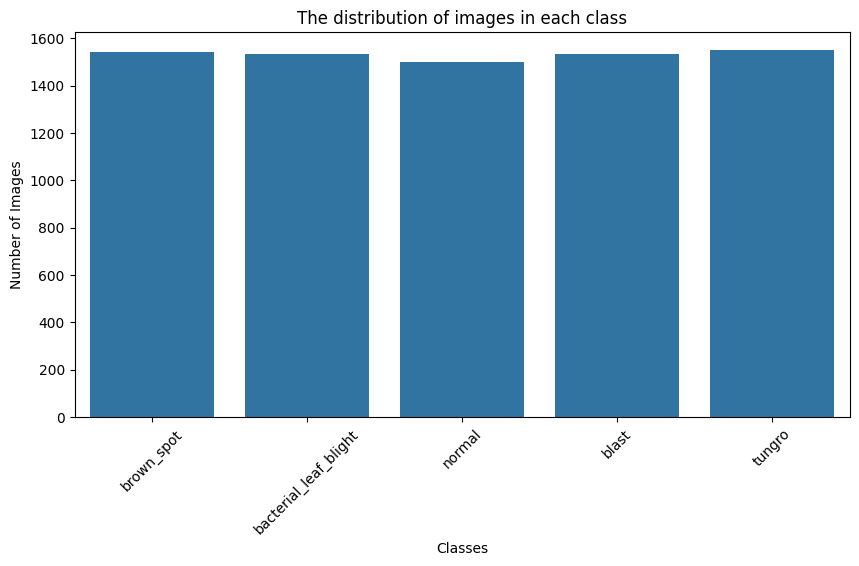

In [ ]:
def perform_eda(train_dir):
    classes = os.listdir(train_dir)
    print(f"Number of Classes: {len(classes)}")
    print(f"Name of Classes: {classes}")

    class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=45)
    plt.title("The distribution of images in each class")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

perform_eda(train_dir)

**MEMVARIASI GAMBAR ATAU AUGMENTASI GAMBAR**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7659 images belonging to 5 classes.
Found 1913 images belonging to 5 classes.


**PEMBOBOTAN KELAS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_labels)),
    y=np.concatenate([np.full(len(train_generator.filepaths[i]), i) for i in range(len(class_labels))])
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


**PRE TRAIN MODEL**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(229, 229, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 227, 227, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,887,109 (18.64 MB)

 Trainable params: 4,887,109 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 131s 921ms/step - accuracy: 0.2013 - loss: 1.6133 - val_accuracy: 0.1939 - val_loss: 1.6095
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 790ms/step - accuracy: 0.2058 - loss: 1.6097 - val_accuracy: 0.2002 - val_loss: 1.6094
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 786ms/step - accuracy: 0.2081 - loss: 1.6093 - val_accuracy: 0.2018 - val_loss: 1.6094
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 790ms/step - accuracy: 0.1950 - loss: 1.6096 - val_accuracy: 0.2018 - val_loss: 1.6094
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 785ms/step - accuracy: 0.2007 - loss: 1.6096 - val_accuracy: 0.2023 - val_loss: 1.6093


**USING TRANSFER LEARNING (EfficientNetB1)**

In [ ]:
#from tensorflow.keras.applications import EfficientNetB1
#from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = True

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 6,936,716 (26.46 MB)

 Trainable params: 6,874,661 (26.22 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=65,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2111 - loss: 1.6911 - val_accuracy: 0.2023 - val_loss: 1.6096
Epoch 2/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 798ms/step - accuracy: 0.2786 - loss: 1.5846 - val_accuracy: 0.2028 - val_loss: 1.6077
Epoch 3/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 802ms/step - accuracy: 0.3484 - loss: 1.4921 - val_accuracy: 0.2018 - val_loss: 1.6066
Epoch 4/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 799ms/step - accuracy: 0.4161 - loss: 1.3860 - val_accuracy: 0.1668 - val_loss: 1.6189
Epoch 5/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - accuracy: 0.5040 - loss: 1.2457 - val_accuracy: 0.2781 - val_loss: 1.5688
Epoch 6/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 801ms/step - accuracy: 0.5596 - loss: 1.1241 - val_accuracy: 0.4715 - val_loss: 1.2633
Epoch 7/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - accuracy: 0.5968 - loss: 1.0248 - val_accuracy: 0.6200 - val_loss: 0.9744
Epoch 8/65
120/120 ━━━━━━━━━━━━━━━━━━━━ 104s 821ms/step - accuracy: 0.6377 - lo

**PLOT FOR ACCURACY AND LOSS**

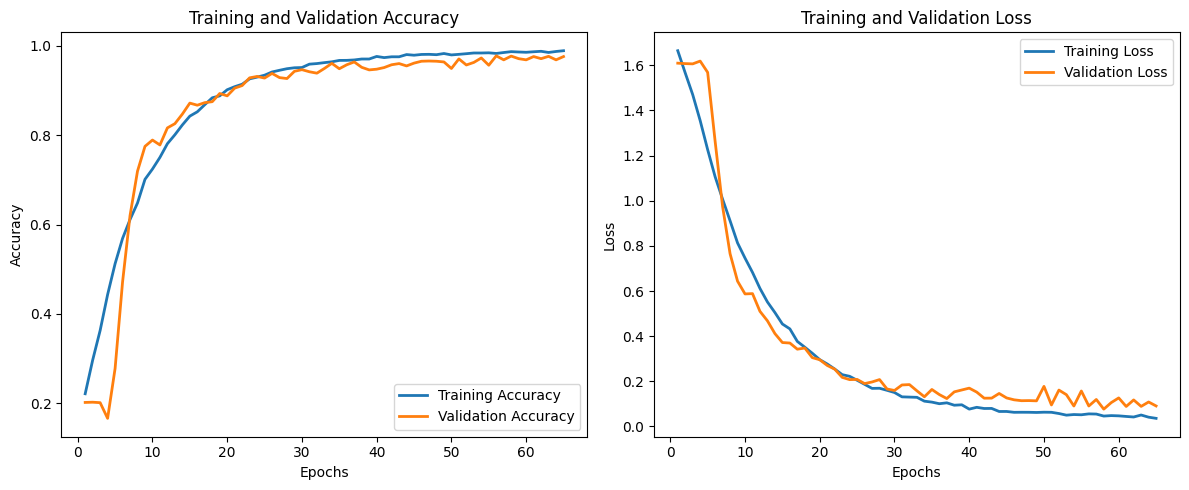

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


**USING FINE TUNING**

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), #With lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9885 - loss: 0.0410 - val_accuracy: 0.9760 - val_loss: 0.0913
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 800ms/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.9739 - val_loss: 0.0970
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 797ms/step - accuracy: 0.9881 - loss: 0.0341 - val_accuracy: 0.9733 - val_loss: 0.0972
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 794ms/step - accuracy: 0.9881 - loss: 0.0367 - val_accuracy: 0.9728 - val_loss: 0.0988
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 796ms/step - accuracy: 0.9850 - loss: 0.0459 - val_accuracy: 0.9739 - val_loss: 0.1006
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 796ms/step - accuracy: 0.9864 - loss: 0.0368 - val_accuracy: 0.9754 - val_loss: 0.0950
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 793ms/step - accuracy: 0.9907 - loss: 0.0326 - val_accuracy: 0.9744 - val_loss: 0.0947
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 795ms/step - accuracy: 0.9892 - lo

**TESTING**

Saving 107705.jpg to 107705.jpg
Saving 107706.jpg to 107706.jpg
Saving 107711.jpg to 107711.jpg


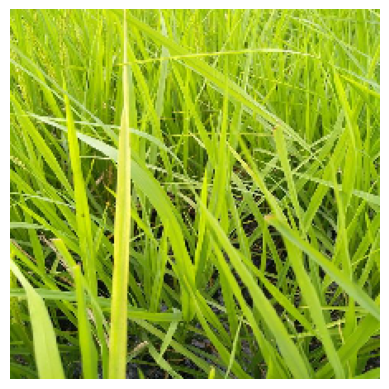

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 100.00%
brown_spot: 0.00%
normal: 0.00%
tungro: 0.00%

Result:
blast: 100.00%


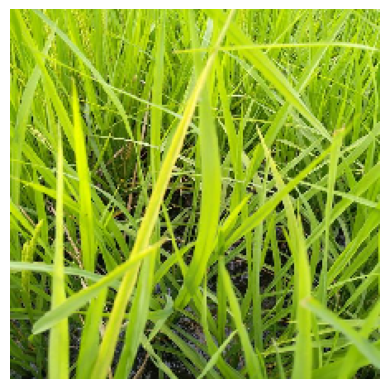

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 0.00%
brown_spot: 0.00%
normal: 100.00%
tungro: 0.00%

Result:
normal: 100.00%


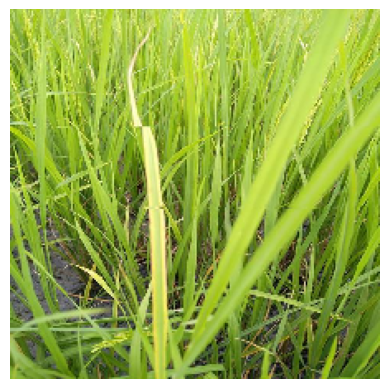

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 0.00%
brown_spot: 100.00%
normal: 0.00%
tungro: 0.00%

Result:
brown_spot: 100.00%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for filepath in uploaded.keys():
    img = image.load_img(filepath, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    proba = model.predict(x, verbose=0)[0]

    print("Prediction probabilities:")
    for label, probability in zip(labels, proba):
        print(f"{label}: {probability * 100:.2f}%")

    max_index = np.argmax(proba)
    max_label = labels[max_index]
    max_proba = proba[max_index]

    print("\nResult:")
    if max_proba >= 0.5:
        print(f"{max_label}: {max_proba * 100:.2f}%")
    else:
        print("Hasil tidak ditemukan!")


**CONFUSSION MATRIX**

Found 1913 images belonging to 5 classes.
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 490ms/step


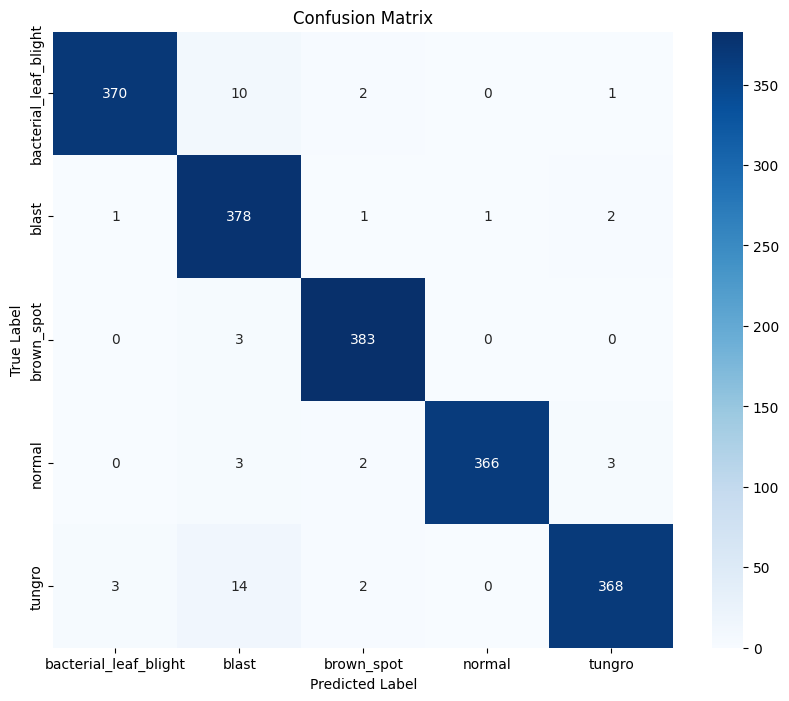

Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.97      0.98       383
                blast       0.93      0.99      0.96       383
           brown_spot       0.98      0.99      0.99       386
               normal       1.00      0.98      0.99       374
               tungro       0.98      0.95      0.97       387

             accuracy                           0.97      1913
            macro avg       0.98      0.97      0.98      1913
         weighted avg       0.98      0.97      0.98      1913



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))


**SAVE THE MODEL**

In [ ]:
model.save('model_padicare.h5')

TypeError: cannot pickle 'module' object

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model_RIPAD_PART2.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model_RIPAD_PART2.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzp6iq5bp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139106919657392: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139106919658448: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139106919660384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919681712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919678016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919680480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919681008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919686640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919686288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139106919688048: TensorSpec(shape=(), dtype=tf.resource, name=Non